# Chapter 7 – Ensemble Learning and Random Forests

In [1]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ensembles` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

- Suppose you pose a complex question to thousands of random people, then aggregate their answers.
- In many cases you will find that this aggregated answer is better than an expert’s answer.
- This is called the **wisdom of the crowd**.

- Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor.
- A group of predictors is called an **ensemble**; thus, this technique is called **ensemble learning**, and an ensemble learning algorithm is called an ensemble method.

- As an example of an ensemble method, you can train a group of decision tree classifiers, each on a different random subset of the training set.
- You can then obtain the predictions of all the individual trees, and the class that gets the most votes is the ensemble’s prediction (Studi kasus part II pertemuan sebelumnya).
- Such an ensemble of decision trees is called a **random forest**, and despite its simplicity, this is one of the most powerful machine learning algorithms available today.

- The winning solutions in machine learning competitions often involve several ensemble methods—most famously in the Netflix Prize competition.

In this chapter we will examine the most popular ensemble methods, including
- voting classifiers,
- bagging and pasting ensembles,
- random forests, and
- boosting, and
- stacking ensembles.

## Voting Classifiers

- Suppose you have trained a few classifiers, each one achieving about 80% accuracy.
- You may have a logistic regression classifier, an SVM classifier, a random forest classifier, a k-nearest neighbors classifier, and perhaps a few more.

<div>
    <img src="images-ch07/diverse.png" width=800/>
</div>
<center>
Training diverse classifiers
</center>

<div>
    <img src="images-ch07/hard-voting.png" width=800/>
</div>    
<center>
    Hard voting classifier predictions
</center>    

- Scikit-Learn provides a `VotingClassifier` class that’s quite easy to use: just give it a list of name/predictor pairs, and use it like a normal classifier.
- Let’s try it on the `moons` dataset.
- We will load and split the `moons` dataset into a training set and a test set, then we’ll create and train a voting classifier composed of three diverse classifiers:

In [5]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

To begin, let’s look at each fitted classifier’s accuracy on the test set:

In [6]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


- When you call the voting classifier’s `predict()` method, it performs hard voting.
- For example, the voting classifier predicts class 1 for the first instance of the test set, because two out of three classifiers predict that class:

In [7]:
voting_clf.predict(X_test[:1])

array([1])

In [8]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

Now let’s look at the performance of the voting classifier on the test set:

In [9]:
voting_clf.score(X_test, y_test)

0.912

There you have it! The voting classifier outperforms all the individual classifiers.

- If all classifiers are able to estimate class probabilities (i.e., if they all have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers.

- This is called _soft voting_.

- It often achieves higher performance than hard voting because it gives more weight to highly confident votes.
- All you need to do is set the voting classifier’s voting hyperparameter to "soft" , and ensure that all classifiers can estimate class probabilities.
- This is not the case for the SVC class by default, so you need to set its probability hyperparameter to `True` (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a `predict_proba()` method).

In [10]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

We reach 92% accuracy simply by using soft voting—not bad!

# Bagging and Pasting
## Bagging and Pasting in Scikit-Learn

- One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed.
- Another approach is to use the same training algorithm for every predictor but train them on different random subsets of the training set.
- When sampling is performed with replacement, this method is called **bagging** (short for **bootstrap aggregating**).
- When sampling is performed **without replacement**, it is called **pasting**.

## Bootstrap menurut Oxford Learners Dictionaries
- bootstrap (noun): (on a computer) the process of loading a program, usually an operating system, by first loading a smaller program.    
Contoh kalimat:
    _This ensures that the operating system bootstrap process does not introduce malware._

All the images below are taken from [Machine learning in Python with scikit-learn](https://www.fun-mooc.fr/en/courses/machine-learning-python-scikit-learn/).

## Bagging for Classification (1/2)
<div>
    <img src="images-ch07/bagging-01.png" width=800>
</div>

## Bagging for Classification (2/2)
<div>
    <img src="images-ch07/bagging-02.png" width=800>
</div>

## Bagging for Regression (1/)
<div>
    <img src="images-ch07/bagging-04.png" width=800>
</div>

## Bagging for Regression (2/)
<div>
    <img src="images-ch07/bagging-05.png" width=1200>
</div>

## Bagging for Regression (1/2)
<div>
    <img src="images-ch07/bagging-06.png" width=1200>
</div>

## Bagging for Regression (1/2)
<div>
    <img src="images-ch07/bagging-07.png" width=1200>
</div>

## Bagging and Pasting in Scikit-Learn
- Scikit-Learn offers a simple API for both bagging and pasting: `BaggingClassifier` class (or `BaggingRegressor` for regression).

- The following code trains an ensemble of 500 decision tree classifiers: 6 each is trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set `bootstrap=False`).
- The `n_jobs` parameter tells Scikit-Learn the number of CPU cores to use for training and predictions, and `-1` tells Scikit-Learn to use all available cores.

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

- Figure below compares the decision boundary of a single decision tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on the moons dataset.
- As you can see, the ensemble’s predictions will likely generalize much better than the single decision tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

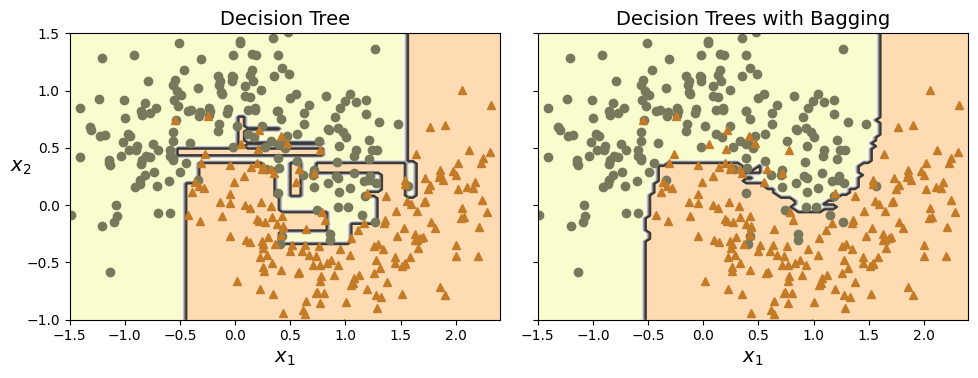

In [12]:
# extra code – this cell generates and saves Figure 7–5
import numpy as np

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Random Forests

- A random forest 10 is an ensemble of decision trees, generally trained via the _bagging_ method (or sometimes _pasting_), typically with `max_samples` set to the size of the training set.
- Instead of building a BaggingClassifier and passing it a `DecisionTreeClassifier`, you can use the `RandomForestClassifier` class, which is more convenient and optimized for decision trees (similarly, there
is a `RandomForestRegressor` class for regression tasks).

- The following code trains a random forest classifier with 500 trees, each limited to maximum 16 leaf nodes, using all available CPU cores:

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), **plus** all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.   
    
    

- The random forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features.

- By default, it samples $n$ features (where $n$ is the total number of features).
- The algorithm results in greater tree diversity, which (again) trades a higher bias for a lower variance, generally yielding an overall better model.
- So, the following `BaggingClassifier` is equivalent to the previous `RandomForestClassifier`:

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [15]:
# extra code – verifies that the predictions are identical
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # same predictions

np.True_

## Feature Importance
- Yet another great quality of random forests is that they make it easy to measure the relative importance of each feature.
- Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest.

- More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.

- Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1.
- You can access the result using the `feature_importances_` variable.

- For example, the following code trains a `RandomForestClassifier` on the iris dataset and outputs each feature’s importance.
- It seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively):

In [16]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


Similarly, if you train a random forest classifier on the MNIST dataset and plot each pixel’s importance, you get the image represented in Figure below.

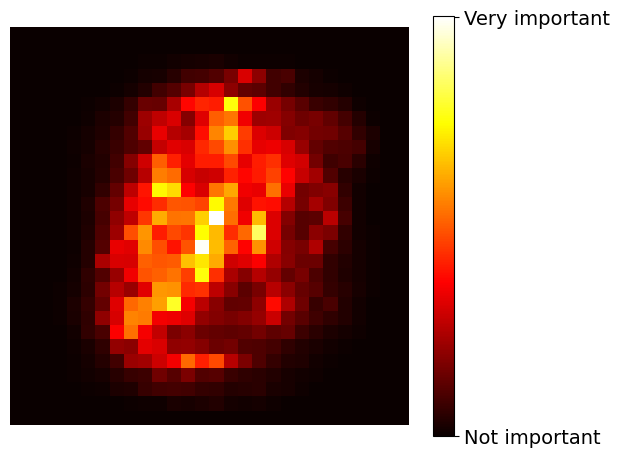

In [17]:
# extra code – this cell generates and saves Figure 7–6

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

Random forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

## Boosting for Classification

<div>
    <img src="images-ch07/boosting-01.png" width=800>
</div>    

<div>
    <img src="images-ch07/boosting-02.png" width=800>
</div>    

<div>
    <img src="images-ch07/boosting-03.png" width=800>
</div>    

<div>
    <img src="images-ch07/boosting-04.png" width=800>
</div>    

## Boosting for Regression

<div>
    <img src="images-ch07/boosting-05.png" width=800>
</div>    

<div>
    <img src="images-ch07/boosting-06.png" width=800>
</div>    

<div>
    <img src="images-ch07/boosting-07.png" width=800>
</div>    

<div>
    <img src="images-ch07/boosting-08.png" width=800>
</div>    

<div>
    <img src="images-ch07/boosting-09.png" width=800>
</div>    

<div>
    <img src="images-ch07/boosting-10.png" width=800>
</div>    

<div>
    <img src="images-ch07/boosting-11.png" width=800>
</div>    

<div>
    <img src="images-ch07/boosting-12.png" width=800>
</div>    

<div>
    <img src="images-ch07/boosting-13.png" width=800>
</div>    

<div>
    <img src="images-ch07/boosting-14.png" width=800>
</div>    

## Boosting
- Boosting (originally called _hypothesis boosting_) refers to any ensemble method that can combine several weak learners into a strong learner.
- The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

- There are many boosting methods available, but by far the most popular are AdaBoost (short for adaptive boosting) and gradient boosting. Let’s start with AdaBoost.

## Adaboost
- One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfit.
- This results in new predictors focusing more and more on the hard cases.
- This is the technique used by **AdaBoost**.

<div>
    <img src="images-ch07/adaboost.png" width=800>
</div>    
<center>
    <i>AdaBoost sequential training with instance weight updates</i>
</center>    

- Figure below shows the decision boundaries of five consecutive predictors on the `moons` dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel).
- The first classifier gets many instances wrong, so their weights get boosted.

- The second classifier therefore does a better job on these instances, and so on.
- The plot on the right represents the same sequence of predictors, except that the learning rate is halved (i.e., the misclassified instance weights are boosted much less at every iteration).

- As you can see, this sequential learning technique has some similarities with gradient descent, except that instead of tweaking a single predictor’s parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.

- Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

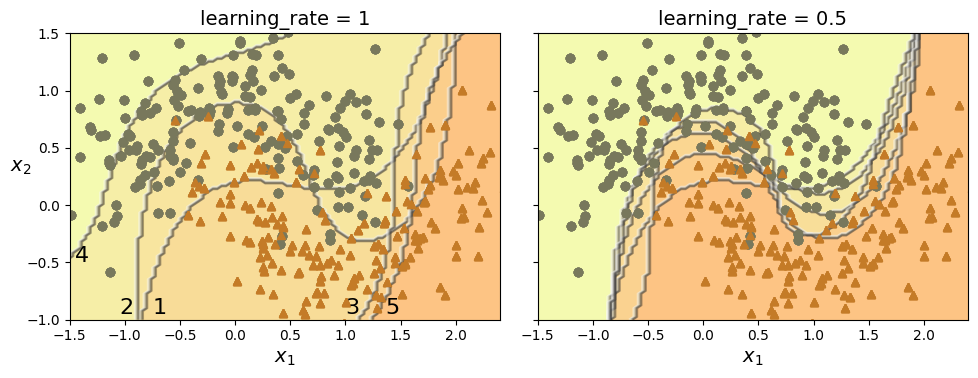

In [18]:
# extra code – this cell generates and saves Figure 7–8

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

- Let’s take a closer look at the **AdaBoost** algorithm.
- Each instance weight $w^{(i)}$ is initially set to $1/m$.
- A first predictor is trained, and its weighted error rate $r_1$ is computed on the training set; see Equation 7-1.

<div>
    <img src="images-ch07/eq-07-01.png" width=800/>
</div>

- The predictor’s weight $\alpha_j$ is then computed using Equation 7-2, where $\eta$ is the learning rate hyperparameter (defaults to 1).
- The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero.
- However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.

<div>
    <img src="images-ch07/eq-07-02.png" width=800/>
</div>

- Next, the AdaBoost algorithm updates the instance weights, using Equation 7-3, which boosts the weights of the misclassified instances.

<div>
    <img src="images-ch07/eq-07-03.png" width=800/>
</div>

- Then all the instance weights are normalized (i.e., divided by $\sum_{i=1}^m w$).

- Finally, a new predictor is trained using the updated weights, and the whole process is repeated: the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on.
- _The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found._

- To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$.
- The predicted class is the one that receives the majority of weighted votes (see Equation 7-4).

<div>
    <img src="images-ch07/eq-07-04.png" width=800/>
</div>

- The following code trains an AdaBoost classifier based on 30 decision stumps using Scikit-Learn’s `AdaBoostClassifier` class (as you might expect, there is also an `AdaBoostRegressor` class).
- A decision stump is a decision tree with `max_depth=1`; in other words, a tree composed of a single decision node plus two leaf nodes.
- This is the default base estimator for the `AdaBoostClassifier` class:

In [19]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

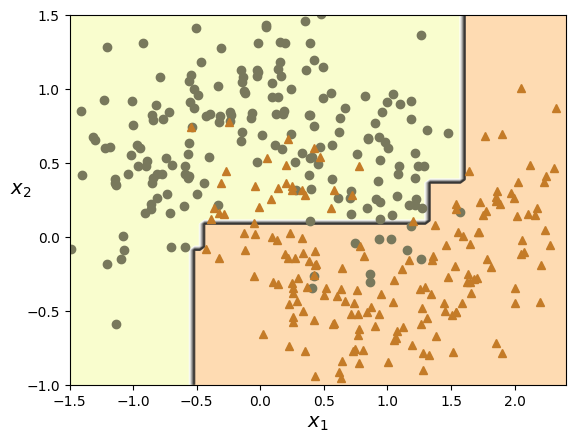

In [20]:
# extra code – in case you're curious to see what the decision boundary
#              looks like for the AdaBoost classifier
plot_decision_boundary(ada_clf, X_train, y_train)

## Gradient Boosting
- Another very popular boosting algorithm is gradient boosting.
- Just like AdaBoost, gradient boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor.
- However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

- Let’s go through a simple regression example, using decision trees as the base predictors; this is called **gradient tree boosting**, or **gradient boosted regression trees** (GBRT).
- First, let’s generate a noisy quadratic dataset and fit a `DecisionTreeRegressor` to it:

In [21]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Next, we’ll train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [22]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

And then we’ll train a third regressor on the residual errors made by the second predictor:

In [23]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [24]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

- Figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column.
- In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions.
- In the second row, a new tree is trained on the residual errors of the first tree.

- On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees.
- Similarly, in the third row another tree is trained on the residual errors of the second tree.
- You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

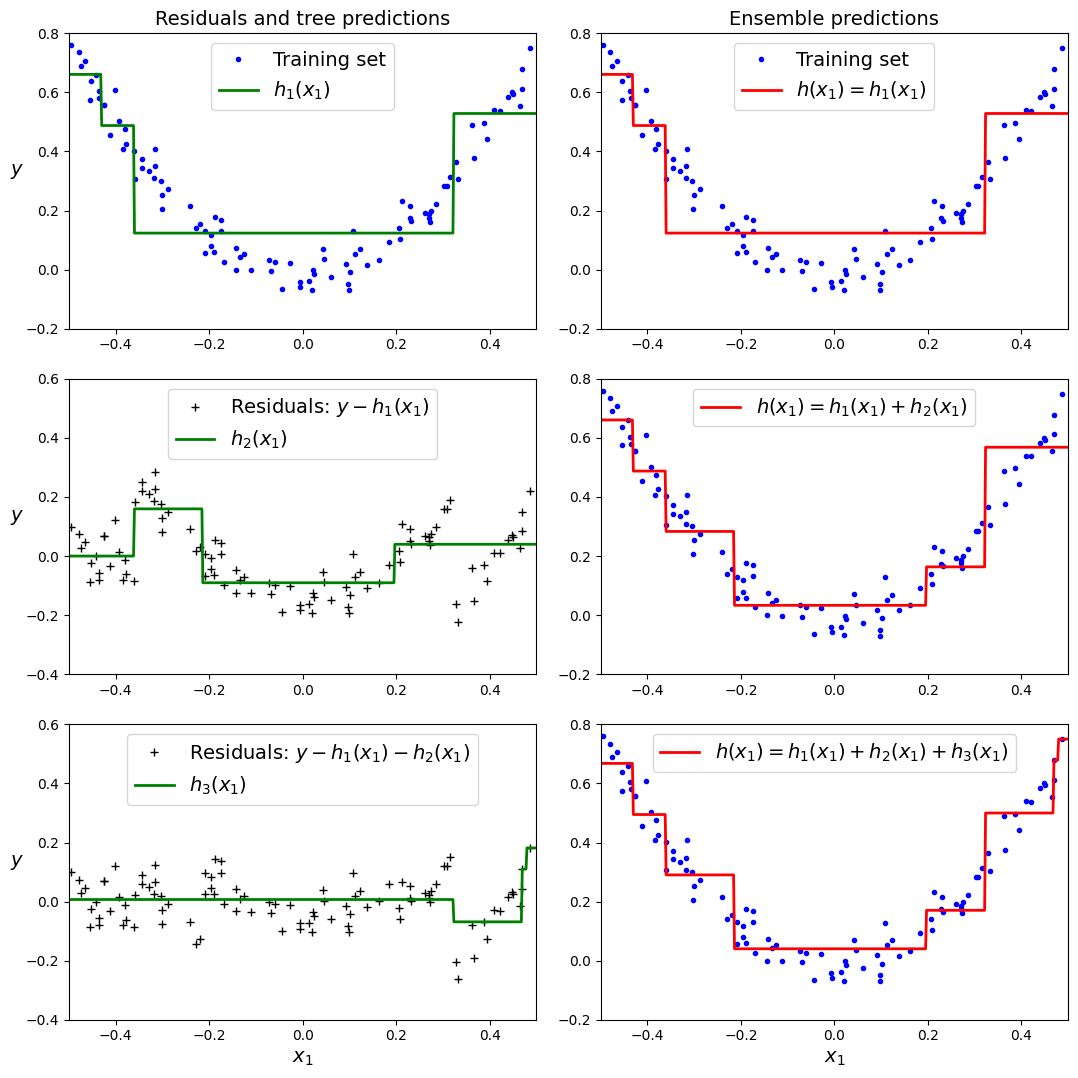

In [25]:
# extra code – this cell generates and saves Figure 7–9

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")
plt.show()

- You can use Scikit-Learn’s `GradientBoostingRegressor` class to train GBRT ensembles more easily (there’s also a `GradientBoostingClassifier` class for classification).
- Much like the `RandomForestRegressor` class, it has hyperparameters to control the growth of decision trees (e.g., `max_depth`, `min_samples_leaf`), as well as hyperparameters to control the ensemble training, such as the number of trees (`n_estimators`).
- The following code creates the same ensemble as the previous one:

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

- The `learning_rate` hyperparameter scales the contribution of each tree.
- If you set it to a low value, such as 0.05 , you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better.
- This is a regularization technique called **shrinkage**.

- Figure below shows two GBRT ensembles trained with different hyperparameters: the one on the left does not have enough trees to fit the training set, while the one on the right has about the right amount.
- If we added more trees, the GBRT would start to overfit the training set.

In [27]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

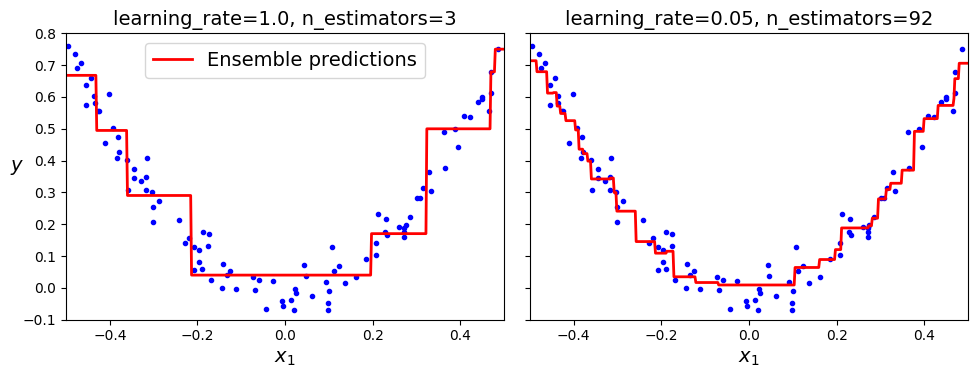

In [28]:
# extra code – this cell generates and saves Figure 7–10

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")

save_fig("gbrt_learning_rate_plot")
plt.show()

- To find the optimal number of trees, you could perform cross-validation using `GridSearchCV` or `RandomizedSearchCV` , as usual, but there’s a simpler way: if you set the `n_iter_no_change` hyperparameter to an integer value, say 10, then the `GradientBoostingRegressor` will automatically stop adding more trees during training if it sees that the last 10 trees didn’t help.

- This is simply early stopping, but with a little bit of patience: it tolerates having no progress for a few iterations before it stops. Let’s train the ensemble using early stopping:

In [29]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

- If you set `n_iter_no_change` too low, training may stop too early and the model will **underfit**.
- But if you set it too high, it will overfit instead.
- We also set a fairly small learning rate and a high number of estimators, but the actual number of estimators in the trained ensemble is much lower, thanks to early stopping:

In [30]:
gbrt_best.n_estimators_

92

Several other optimized implementations of gradient boosting are
available in the Python ML ecosystem: in particular,
- Histogram-based Gradient Boosting (HGB),
- XGBoost,
- CatBoost, and
- LightGBM.

## Stacking
- The last ensemble method we will discuss in this chapter is called stacking (short for **stacked generalization**)
- It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation?

- Figure below shows such an ensemble performing a regression task on a new instance.
- Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor (called a **blender**, or a **meta learner**) takes these predictions as inputs and makes the final prediction (3.0).

<div>
    <img src="images-ch07/stacking-01.png" width=800>
</div>    
<center><i>Aggregating predictions using a blending predictor</i></center>

- To train the blender, you first need to build the blending training set.
- You can use `cross_val_predict()` on every predictor in the ensemble to get out-of-sample predictions for each instance in the original training set, and use these can be used as the input features to train the blender; and the targets can simply be copied from the original training set.

<div>
    <img src="images-ch07/stacking-02.png" width=800>
</div>    
<center><i>Training the blender in a stacking ensemble</i></center>

- Note that regardless of the number of features in the original training set (just one in this example), the blending training set will contain one input feature per predictor (three in this example).
- Once the blender is trained, the base predictors are retrained one last time on the full original training set.

- Scikit-Learn provides two classes for stacking ensembles: `StackingClassifier` and `StackingRegressor`.
- For example, we can replace the `VotingClassifier` we used at the beginning of this chapter on the `moons` dataset with a `StackingClassifier`:

In [31]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

- For each predictor, the stacking classifier will call `predict_proba()` if available; if not it will fall back to `decision_function()` or, as a last resort, call `predict()`.
- If you don’t provide a final estimator, `StackingClassifier` will use `LogisticRegression` and `StackingRegressor` will use `RidgeCV`.

In [32]:
stacking_clf.score(X_test, y_test)

0.928

- If you evaluate this stacking model on the test set, you will find 92.8% accuracy, which is a bit better than the voting classifier using soft voting, which got 92%.

## Conclusion (1/2)
- In conclusion, ensemble methods are versatile, powerful, and fairly simple to use.
- Random forests, AdaBoost, and GBRT are among the first models you should test for most machine learning tasks, and they particularly shine with heterogeneous tabular data.

## Conclusion (2/2)
- Moreover, as they require very little preprocessing, they’re great for getting a prototype up and running quickly.
- Lastly, ensemble methods like voting classifiers and stacking classifiers can help push your system’s performance to its limits.

<center>
    <h1>The End</h1>
</center>